# Introduction

## Table of Contents
- [Import Libraries](#section1)
- [Modeling](#section2)
    - [Logisitic Regression](#section3)
    - [Random Forest](#section4)
    - [MLP Classifier](#section5)
- [ROC Curves](#section6)

### Import Libraries <a name="section1"></a>
Import necessary libraries and load dataset via the commentpuller class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import CommentPull.CommentPuller
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

In [2]:
#Make graphs pretty and bigger
plt.rcParams['figure.figsize'] = (7, 5)
sns.set()
#Suppress warnings for prettier output
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load data using custom class
comment_puller = CommentPull.CommentPuller.CommentPuller(load=True)

### Modeling <a name="section2"></a>
In this section, the data is split into training a testing sets and scaled with the RobustScaler. This data is then used to train three models: Logisitic Regression, Random Forest Classifier and MLP Classifier. These steps are carried out for both the title data and the text data. ROC_AUC is the metric of choice for this analysis because there are so many more assholes than non-assholes, the accuracy score becomes misleading. ROC_AUC gives the best score for how well the model is doing.

In [4]:
#Split title data
X_title = comment_puller.title_df.drop(['label_id', 'post_id'], axis=1)
y_title = comment_puller.title_df['label_id']
X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(X_title, y_title,
                                                                           test_size=0.15, random_state=10)
#Scale training data
title_scaler = RobustScaler()
X_title_train = title_scaler.fit_transform(X_title_train)

#Scale test data in same manner
X_title_test = title_scaler.transform(X_title_test)

In [5]:
#Split text data 
X_text = comment_puller.text_df.drop(['label_id', 'post_id'], axis=1)
y_text = comment_puller.text_df['label_id']
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text,
                                                                           test_size=0.15, random_state=10)
#Scale training data
text_scaler = RobustScaler()
X_text_train = text_scaler.fit_transform(X_text_train)
#Scale test data in same manner as training
X_text_test = text_scaler.transform(X_text_test)

#### Logisitic Regression <a name="section3"></a> 

In [6]:
#Let's begin with a Logisitic Regression Model
#Intialize model
log_title = LogisticRegression(solver='newton-cg')
#Create a parameter grid over which we can gridsearch
param_grid ={'C':np.logspace(-4, 4, 10) , 'penalty':['l1', 'l2']}
#Intialize a gridsearch object
log_title_gs = GridSearchCV(log_title, param_grid, cv=5, scoring='roc_auc')
#Fit the gridsearch object
log_title_gs.fit(X_title_train, y_title_train)
#Print out best hyperparameters
print('Best parameter for n_neighbors is {}'.format(log_title_gs.best_params_))
print('Scoring {}'.format(log_title_gs.best_score_))

Best parameter for n_neighbors is {'C': 0.3593813663804626, 'penalty': 'l2'}
Scoring 0.6182792536089977


In [7]:
#Intialize final Logistic Regression Model
log_title_final = LogisticRegression(C=0.359, penalty='l2')
#Fit model
log_title_final.fit(X_title_train, y_title_train)
#Get roc_auc score and save predictions for later
log_title_preds = log_title_final.predict_proba(X_title_test)
roc_auc_score(y_title_test, log_title_preds[:, 1])

0.55875

In [8]:
#Intialize model
log_text = LogisticRegression(solver='newton-cg')
#Intialize a gridsearch object
log_text_gs = GridSearchCV(log_text, param_grid, cv=5, scoring='roc_auc')
#Fit the gridsearch object
log_text_gs.fit(X_text_train, y_text_train)
#Print out best hyperparameters
print('Best parameter for n_neighbors is {}'.format(log_text_gs.best_params_))
print('Scoring {}'.format(log_text_gs.best_score_))

Best parameter for n_neighbors is {'C': 0.005994842503189409, 'penalty': 'l2'}
Scoring 0.6237225483991814


In [9]:
#Intialize final Logistic Regression Model
log_text_final = LogisticRegression(C=0.00599, penalty='l2')
#Fit model
log_text_final.fit(X_text_train, y_text_train)
#Get roc_auc score and save predictions for later
log_text_preds = log_text_final.predict_proba(X_text_test)
roc_auc_score(y_text_test, log_text_preds[:, 1])

0.5941287878787879

#### Random Forest Classifier <a name="section4"></a>

In [11]:
#Intialize model for gridsearching
tree_title = RandomForestClassifier(random_state=10)
#Intialize parameter grid
param_grid = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,3,5,7,9],
}
#Gridsearch model
tree_title_gs = GridSearchCV(tree_title, param_grid, cv=5, scoring='roc_auc')
tree_title_gs.fit(X_title_train, y_title_train)
#Get results from grid searching
print('Best parameter for n_neighbors is {}'.format(tree_title_gs.best_params_))
print('Scoring {}'.format(tree_title_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 200}
Scoring 0.6168360069961466


In [12]:
#Creat final tree based on gridsearch parameters
tree_title_final = RandomForestClassifier(max_features='log2', max_depth=3, n_estimators=200)
tree_title_final.fit(X_title_train, y_title_train)
#Get roc_auc score and save predictions for later
title_tree_preds = tree_title_final.predict_proba(X_title_test)
roc_auc_score(y_title_test, title_tree_preds[:, 1])

0.5502462121212119

In [13]:
#Intialize model for gridsearching
tree_text = RandomForestClassifier(random_state=10)
#Gridsearch model using same param_grid as above
tree_text_gs = GridSearchCV(tree_text, param_grid, cv=5, scoring='roc_auc')
tree_text_gs.fit(X_text_train, y_text_train)
#Get results from grid searching
print('Best parameter for n_neighbors is {}'.format(tree_text_gs.best_params_))
print('Scoring {}'.format(tree_text_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
Scoring 0.5537078677487994


In [14]:
#Creat final tree based on gridsearch parameters
tree_text_final = RandomForestClassifier(max_features='log2', max_depth=5, n_estimators=100)
tree_text_final.fit(X_text_train, y_text_train)
#Get roc_auc score and save predictions for later
text_tree_preds = tree_text_final.predict_proba(X_text_test)
roc_auc_score(y_text_test, text_tree_preds[:, 1])

0.5877462121212121

#### MLP Classifier <a name="section5"></a>

In [15]:
#Let's try sklearn's deep learning model to see if we can improve performance
title_mlp = MLPClassifier(max_iter=100)
#Define a paramter space for the gridsearch
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
#Define gridsearch and fit
title_mlp_gs = GridSearchCV(title_mlp, parameter_space, n_jobs=-1, cv=5, scoring='roc_auc')
title_mlp_gs.fit(X_title_train, y_title_train)
#Print results
print('Best parameter for n_neighbors is {}'.format(title_mlp_gs.best_params_))
print('Scoring {}'.format(title_mlp_gs.best_score_))

Best parameter for n_neighbors is {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Scoring 0.603532340276527


In [16]:
#Create final mlp model
title_mlp_final = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=(100,),
                               learning_rate='adaptive', solver='adam', alpha=0.05)
title_mlp_final.fit(X_title_train, y_title_train)
#Get roc_auc score and save predictions
title_mlp_preds = title_mlp_final.predict_proba(X_title_test)
roc_auc_score(y_title_test, title_mlp_preds[:, 1])

0.5385227272727272

In [17]:
#Let's now do the same mlp model but for the text data
text_mlp = MLPClassifier(max_iter=100)
#Define gridsearch and fit. Use same parameter_space as above. 
text_mlp_gs = GridSearchCV(text_mlp, parameter_space, n_jobs=-1, cv=5, scoring='roc_auc')
text_mlp_gs.fit(X_text_train, y_text_train)
#Print results
print('Best parameter for n_neighbors is {}'.format(text_mlp_gs.best_params_))
print('Scoring {}'.format(text_mlp_gs.best_score_))

Best parameter for n_neighbors is {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Scoring 0.63199859060045


In [18]:
#Create final mlp model
text_mlp_final = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=(100,),
                               learning_rate='constant', solver='sgd', alpha=0.0001)
text_mlp_final.fit(X_text_train, y_text_train)
#Get roc_auc score and save predictions
text_mlp_preds = text_mlp_final.predict_proba(X_text_test)
roc_auc_score(y_text_test, text_mlp_preds[:, 1])

0.5970833333333334

### ROC Curves <a name="section6"></a>
In order to compare our models visualy, a roc plot is made for both the title models and the text models. 

Text(0.5, 1.0, 'ROC curves of title models')

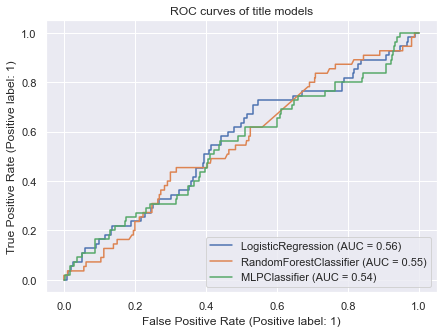

In [19]:
#Let's compare the three title models with an roc curve
from sklearn.metrics import plot_roc_curve
disp = plot_roc_curve(log_title_final, X_title_test, y_title_test)
plot_roc_curve(tree_title_final,  X_title_test, y_title_test, ax=disp.ax_)
plot_roc_curve(title_mlp_final,  X_title_test, y_title_test, ax=disp.ax_)
plt.title('ROC curves of title models')

Text(0.5, 1.0, 'ROC curves of text models')

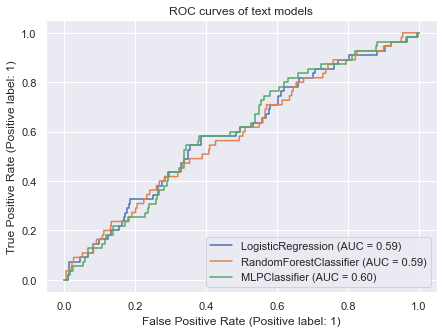

In [20]:
#Do the same but for the text models now
disp = plot_roc_curve(log_text_final, X_text_test, y_text_test)
plot_roc_curve(tree_text_final,  X_text_test, y_text_test, ax=disp.ax_)
plot_roc_curve(text_mlp_final,  X_text_test, y_text_test, ax=disp.ax_)
plt.title('ROC curves of text models')

This section was used to turn the data into a file so that a bot could be trained on the data.

In [ ]:
#For our chat bot, we need to create a text file of post titles, text bodies and comments.
#Create an empty string to write to
text = ""
#Make copies of df's to make code easier to read
post_df = comment_puller.post_df.copy()
comment_df = comment_puller.comment_df.copy()
#Get post for specific post_id
for post_id in post_df['post_id']:
    #Retrieve the post and write the title text and body text
    post = post_df[post_df['post_id']==post_id]
    text += post['title'].values[0] + '\n'
    text += post['post_text'].values[0] + '\n'
    #Get the top ten comments of post saved in comment_df
    comments = comment_df[comment_df['post_id'].isin([post_id])]
    #Write them to the text string
    for comment in comments['comment']:
        text += comment + '/n'
    #Write the titles, text bodies and comments to our file
    f.write(text)
    #Reset text
    text = ""

In [ ]:
f.close()